inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'logistic-regression-hpt'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'


packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [6]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

In [11]:
query = f"""
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection` LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,8748.0,-1.070416,0.304517,2.777064,2.154061,0.254450,-0.448529,-0.398691,0.144672,1.070900,...,-0.122032,-0.182351,0.019576,0.626023,-0.018518,-0.263291,-0.198600,0.098435,0.0,0
1,27074.0,1.165628,0.423671,0.887635,2.740163,-0.338578,-0.142846,-0.055628,-0.015325,-0.213621,...,-0.081184,-0.025694,-0.076609,0.414687,0.631032,0.077322,0.010182,0.019912,0.0,0
2,28292.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.083467,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0
3,28488.0,1.070316,0.079499,1.471856,2.863786,-0.637887,0.858159,-0.687478,0.344146,0.459561,...,0.048067,0.534713,-0.098645,0.129272,0.543737,0.242724,0.065070,0.023500,0.0,0
4,31392.0,-3.680953,-4.183581,2.642743,4.263802,4.643286,-0.225053,-3.733637,1.273037,0.015661,...,0.649051,1.054124,0.795528,-0.901314,-0.425524,0.511675,0.125419,0.243671,0.0,0


In [14]:
dataset_id = f"{BQ_PROJECT}.{BQ_DATASET}"  # e.g., vertexaiproject-454121.fraud
dataset = bigquery.Dataset(dataset_id)
bq.create_dataset(dataset, exists_ok=True)
print(f"Dataset {dataset_id} created or already exists.")

Dataset vertexaiproject-454121.fraud created or already exists.


In [15]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
SELECT
  *,
  CASE
    WHEN RAND() < 0.7 THEN 'TRAIN'
    WHEN RAND() < 0.85 THEN 'VALIDATE'
    ELSE 'TEST'
  END AS splits
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`;
"""
bq.query(query).result()  # Just execute, no dataframe here

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [16]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,12881
1,TEST,1,24
2,TRAIN,0,198797
3,TRAIN,1,357
4,VALIDATE,0,72637
5,VALIDATE,1,111


In [21]:
query = f"""
SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,splits
0,30971.0,1.242351,-0.090043,0.151049,-0.304315,-0.238079,-0.230514,-0.201475,0.108172,0.099752,...,-0.569518,0.101134,-0.277948,0.082921,0.882632,-0.080413,-0.015072,0.0,0,TEST
1,116734.0,1.882176,0.246174,-0.167191,4.057484,-0.093712,0.234933,-0.259799,0.100338,-0.086675,...,0.470923,0.100757,-0.035073,0.053270,0.141382,-0.006323,-0.050050,0.0,0,TEST
2,73868.0,-0.422347,1.531719,1.711154,2.064467,0.742043,-0.149985,0.982804,-0.095459,-1.782018,...,-1.315610,-0.013144,-0.176537,-0.242915,-0.382894,0.084841,0.114663,0.0,0,TEST
3,113772.0,1.890485,0.261331,-0.160093,4.066246,-0.122212,0.146896,-0.239392,0.069196,-0.098295,...,0.455722,0.094141,0.026726,0.069946,0.135425,-0.008944,-0.049222,0.0,0,TEST
4,49884.0,1.050879,0.053408,1.364590,2.666158,-0.378636,1.382032,-0.766202,0.486126,0.152611,...,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0,TEST


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [17]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SUM(n) OVER() as total,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,TEST,0,12881,284807,0.045305,0.998140,0.998273
1,TEST,1,24,284807,0.048780,0.001860,0.001727
2,VALIDATE,0,72637,284807,0.255481,0.998474,0.998273
3,VALIDATE,1,111,284807,0.225610,0.001526,0.001727
4,TRAIN,0,198797,284807,0.699214,0.998207,0.998273
5,TRAIN,1,357,284807,0.725610,0.001793,0.001727


---
## This Run

In [18]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.bqml_{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: vertexaiproject-454121.fraud.bqml_logistic-regression-hpt_20250421151614
This run will create Vertex AI model: vertexaiproject-454121.fraud.bqml_bqml_logistic-regression-hpt
The runs timestamp Is: 20250421151614


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

**Hyperparameter Tuning**

The [following options](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#create_model_syntax) are added to the model training code for BQML to guide the hyperparameter tuning of `L1` and `L2` regularization:

```SQL
l1_reg = HPARAM_RANGE(0, 1000),
l2_reg = HPARAM_RANGE(0, 1000),
hparam_tuning_algorithm = 'VIZIER_DEFAULT',
hparam_tuning_objectives = ['ROC_AUC'],
num_trials = 20,
max_parallel_trials = 2
```

This instructs BQML to use the Vertex AI Vizier service to find values of `l1_reg` and `l2_reg` that optimize 'roc_auc' by doing 4 trials at a time until 20 trials have been completed.


In [22]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 2,
        max_parallel_trials = 2,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT *  ,
    CASE
        WHEN splits = 'VALIDATE' THEN 'EVAL'
        ELSE splits
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `vertexaiproject-454121.fraud.bqml_logistic-regression-hpt_20250421151614`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 2,
        max_parallel_trials = 2,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_bqml_logistic-regression-hpt',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20250421151614']
    ) AS
SELECT *  ,
    CASE
        WHEN splits = 'VALIDATE' THEN 'EVAL'
        ELSE splits
    END AS custom_splits
FROM `vertexaiproject-454121.fraud.fraud_prepped`



In [23]:
job = bq.query(query = query)
job.result()

In [24]:
(job.ended-job.started).total_seconds()

224.627

In [25]:
job.total_bytes_processed

145662248

Add labels to the model in BigQuery:

In [26]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [27]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121


In [28]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!5m3!1svertexaiproject-454121!2sfraud!3sbqml_logistic-regression-hpt_20250421151614



BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/vertexaiproject-454121/queries/8535fb9f-2dc3-4352-87af-6f0b3a07354c?maxResults=0&location=US&prettyPrint=false: Column transaction_id in SELECT * EXCEPT list does not exist at [20:17]

Location: US
Job ID: 8535fb9f-2dc3-4352-87af-6f0b3a07354c### Check out this model in the Vertex AI Model Registry

In [29]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_logistic-regression-hpt_20250421151614?project=vertexaiproject-454121


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [30]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94904.989942,84934.000000,47500.511938,<NA>,0,<NA>
1,V1,-46.855047,2.451888,0.002149,-0.009937,1.956945,<NA>,0,<NA>
2,V2,-63.344698,19.167239,0.001442,0.063744,1.639945,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.003321,0.180913,1.519075,<NA>,0,<NA>
4,V4,-5.683171,16.715537,-0.000148,-0.029010,1.414478,<NA>,0,<NA>
5,V5,-113.743307,32.911462,0.001032,-0.038687,1.385195,<NA>,0,<NA>
6,V6,-21.929312,73.301626,-0.001062,-0.280962,1.332914,<NA>,0,<NA>
7,V7,-37.060311,120.589494,0.002199,0.030034,1.239462,<NA>,0,<NA>
8,V8,-73.216718,19.168327,-0.000932,0.019168,1.199069,<NA>,0,<NA>
9,V9,-11.126624,15.594995,-0.002194,-0.042363,1.096078,<NA>,0,<NA>


Retrieve the trial info for the hyperparameter tuning trials with [ML.TRIAL_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-trial-info):

In [31]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1e-14}",{'roc_auc': 0.981962037962038},0.112041,0.32997,SUCCEEDED,None,True
1,2,"{'l1_reg': 5.415347757053911e-11, 'l2_reg': 5....",{'roc_auc': 0.981962037962038},0.112041,0.32997,SUCCEEDED,None,True


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [32]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,1,0.013823,0.945946,0.896946,0.027248,0.329970,0.981962
1,TEST,1,0.018251,1.000000,0.899961,0.035848,0.329796,0.997107
2,TRAIN,1,0.072117,0.921569,0.978604,0.133767,0.112041,0.985370


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [33]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,1,0,194564,4233
1,1,1,28,329


In [34]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,1,0,65146,7491
1,1,1,6,105


In [35]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,1,0,11590,1291
1,1,1,0,24


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [36]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1,1.000000,0.011204,0.000000,4,0,198797,353
1,1,0.773164,0.887955,0.008531,317,1696,197101,40
2,1,0.544658,0.918768,0.018260,328,3630,195167,29
3,1,0.418569,0.929972,0.028421,332,5650,193147,25
4,1,0.346219,0.938375,0.038547,335,7663,191134,22


In [37]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1,1.000000,0.036036,0.000000,4,0,72637,107
1,1,0.936676,0.864865,0.008756,96,636,72001,15
2,1,0.836843,0.882883,0.018806,98,1366,71271,13
3,1,0.762331,0.882883,0.028883,98,2098,70539,13
4,1,0.703036,0.882883,0.039071,98,2838,69799,13


In [38]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1,1.000000,0.041667,0.000000,1,0,12881,23
1,1,0.950109,0.916667,0.008462,22,109,12772,2
2,1,0.855175,0.916667,0.018322,22,236,12645,2
3,1,0.756354,0.958333,0.028492,23,367,12514,1
4,1,0.694822,0.958333,0.038506,23,496,12385,1


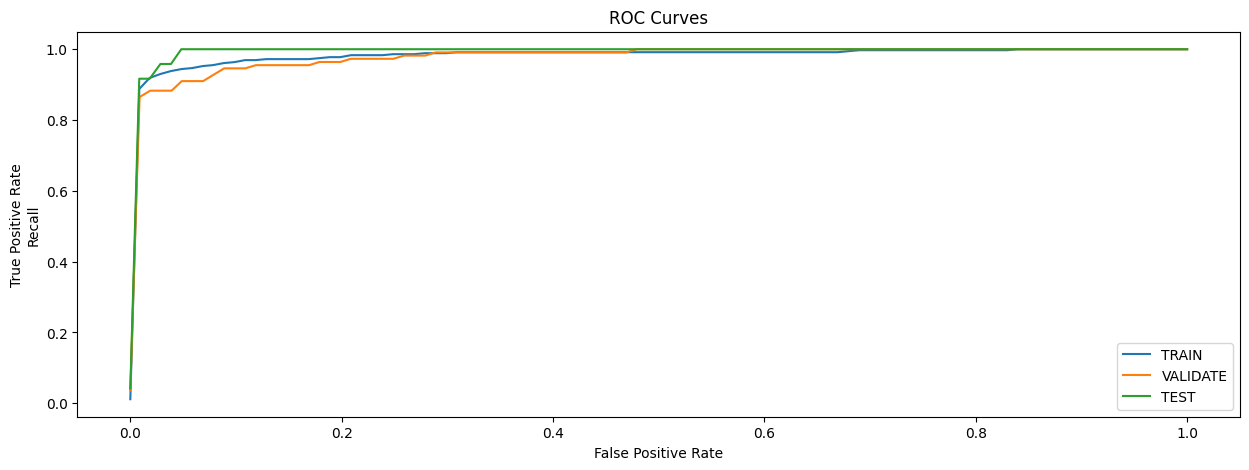

In [39]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [40]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [41]:
pred.columns

Index(['trial_id', 'predicted_Class', 'predicted_Class_probs', 'Time', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [42]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.09379108221146912}, {'...",TEST
1,0,1,"[{'label': 1, 'prob': 0.7481948417972909}, {'l...",TEST
2,0,0,"[{'label': 1, 'prob': 0.20434886983761785}, {'...",TEST
3,0,1,"[{'label': 1, 'prob': 0.7477750066606237}, {'l...",TEST
4,0,0,"[{'label': 1, 'prob': 0.37985269161726803}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prob`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [43]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.9062089177885309},
  {'label': 1, 'prob': 0.09379108221146912}]]

---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [44]:
metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

array([[11590,  1291],
       [    0,    24]])

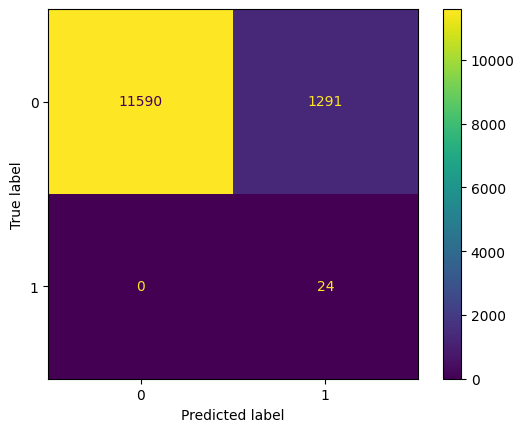

In [45]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [46]:
metrics.accuracy_score(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

0.8999612553273925

In [47]:
print(metrics.classification_report(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     12881
           1       0.02      1.00      0.04        24

    accuracy                           0.90     12905
   macro avg       0.51      0.95      0.49     12905
weighted avg       1.00      0.90      0.95     12905



---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [48]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [49]:
explain.head()

,trial_id,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,splits
0,1,0,0.906209,"[{'feature': 'V14', 'attribution': -0.50528652...",-1.491018,-2.268200,0.0,30971.0,1.242351,-0.090043,...,-0.569518,0.101134,-0.277948,0.082921,0.882632,-0.080413,-0.015072,0.0,0,TEST
1,1,1,0.748195,"[{'feature': 'V4', 'attribution': 2.5625917069...",-1.491018,1.089008,0.0,116734.0,1.882176,0.246174,...,0.470923,0.100757,-0.035073,0.053270,0.141382,-0.006323,-0.050050,0.0,0,TEST
2,1,0,0.795651,"[{'feature': 'V4', 'attribution': 1.3039048188...",-1.491018,-1.359332,0.0,73868.0,-0.422347,1.531719,...,-1.315610,-0.013144,-0.176537,-0.242915,-0.382894,0.084841,0.114663,0.0,0,TEST
3,1,1,0.747775,"[{'feature': 'V4', 'attribution': 2.5681254175...",-1.491018,1.086781,0.0,113772.0,1.890485,0.261331,...,0.455722,0.094141,0.026726,0.069946,0.135425,-0.008944,-0.049222,0.0,0,TEST
4,1,0,0.620147,"[{'feature': 'V4', 'attribution': 1.6839016639...",-1.491018,-0.490174,0.0,49884.0,1.050879,0.053408,...,0.624424,-0.157228,-0.240411,0.573061,0.244090,0.063834,0.010981,0.0,0,TEST


Create a plot of feature attributions for a single prediction:

In [50]:
explanation = explain.iloc[0]['top_feature_attributions']

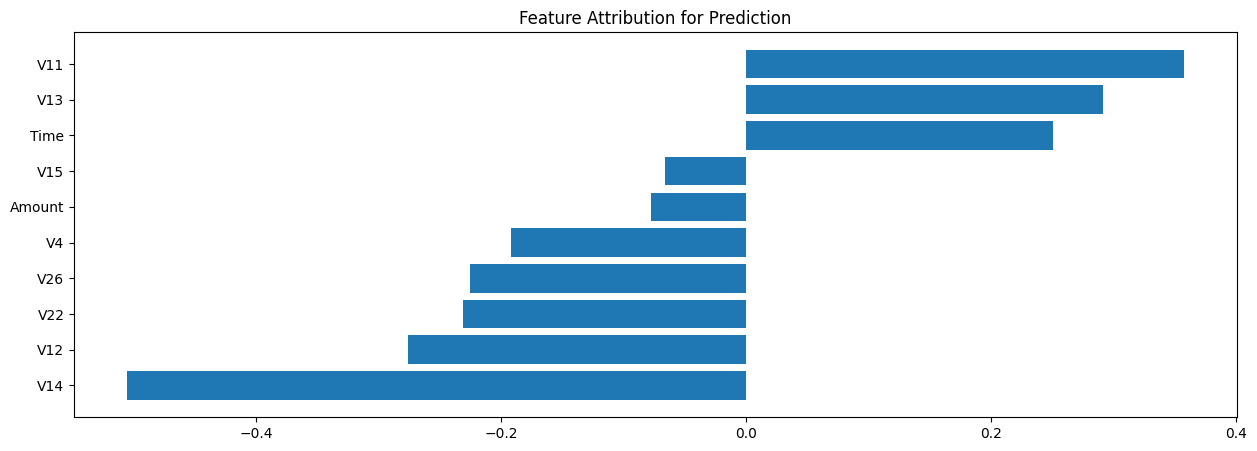

In [51]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [52]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [53]:
gexplain.head()

,trial_id,feature,attribution
0,1,V4,0.685852
1,1,V14,0.518143
2,1,V12,0.468498
3,1,V13,0.282753
4,1,V22,0.251519


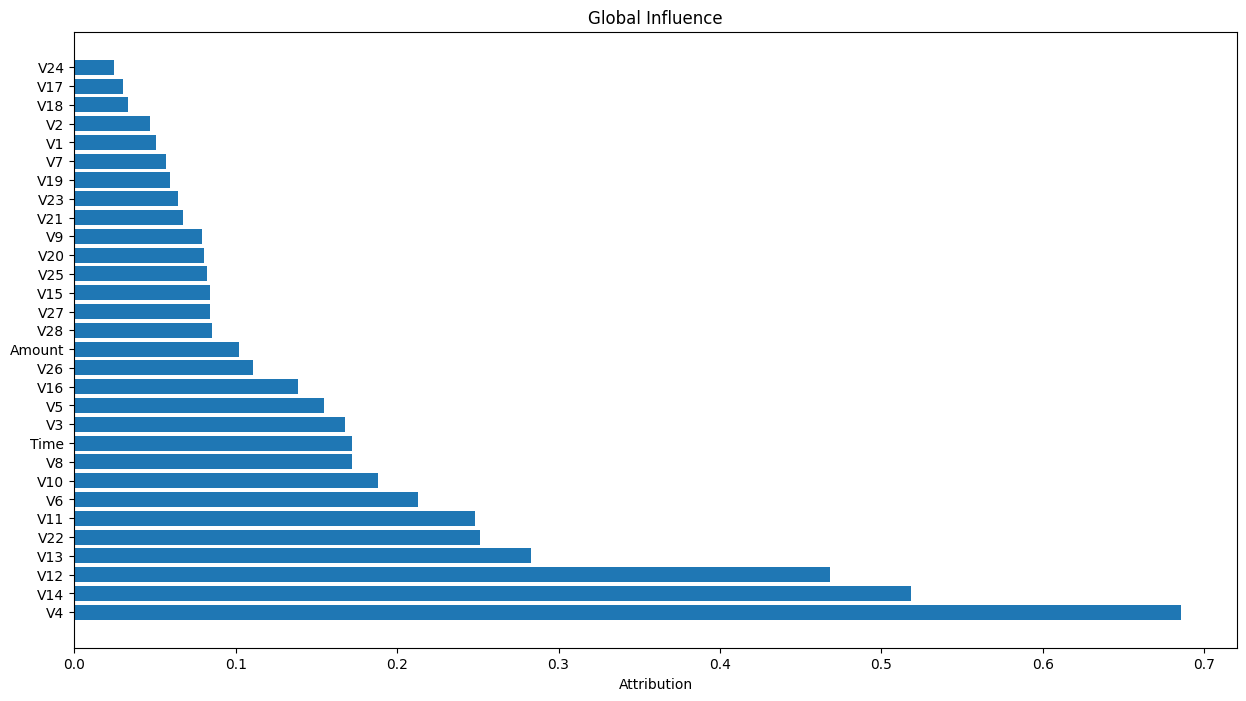

In [54]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [55]:
vertex_model = aiplatform.Model(model_name = f'bqml_{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

'projects/918019863602/locations/us-central1/models/bqml_bqml_logistic-regression-hpt'

In [56]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

In [57]:
vertex_model.gca_resource

name: "projects/918019863602/locations/us-central1/models/bqml_bqml_logistic-regression-hpt"
display_name: "bqml_bqml_logistic-regression-hpt"
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1745249981
  nanos: 246803000
}
update_time {
  seconds: 1745249981
  nanos: 246803000
}
etag: "AMEw9yPX9_4kBTyx3jQjmBM8kvM4m1-xtkeKOmpdKKVjpAmdVOJ-YYRf6ZObxMSsSU8="
labels {
  key: "experiment"
  value: "logistic-regression-hpt"
}
labels {
  key: "series"
  value: "bqml"
}
version_id: "1"
version_aliases: "run-20250421151614"
version_aliases: "default"
version_create_time {
  seconds: 1745249981
  nanos: 246803000
}
ve

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [58]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Creating Endpoint
Create Endpoint backing LRO: projects/918019863602/locations/us-central1/endpoints/8751502328143544320/operations/3464220943352594432
Endpoint created. Resource name: projects/918019863602/locations/us-central1/endpoints/8751502328143544320
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/918019863602/locations/us-central1/endpoints/8751502328143544320')
Endpoint Created: bqml


In [59]:
endpoint.display_name

'bqml'

In [60]:
endpoint.traffic_split

{}

In [61]:
deployed_models = endpoint.list_models()
for d in deployed_models: print(d.display_name)

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [ ]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = aiplatform.explain.ExplanationParameters(), # supress the explanation specs from BQML during deployment
    explanation_metadata = aiplatform.explain.ExplanationMetadata(),
)

Deploying Model projects/918019863602/locations/us-central1/models/bqml_bqml_logistic-regression-hpt to Endpoint : projects/918019863602/locations/us-central1/endpoints/8751502328143544320
Deploy Endpoint model backing LRO: projects/918019863602/locations/us-central1/endpoints/8751502328143544320/operations/7846223380784087040


---
# DEBUGGING

ERROR related to explanationspec from BQML registering model in Vertex AI Model Registry.  View the spec with `vertex_model.gca_resource`

---

In [63]:
endpoint.list_models()

[]

### Remove Deployed Models without Traffic

In [64]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

In [65]:
endpoint.traffic_split

{}

In [66]:
#endpoint.list_models()

---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [67]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

BadRequest: 400 Column transaction_id in SELECT * EXCEPT list does not exist at [2:32]; reason: invalidQuery, location: query, message: Column transaction_id in SELECT * EXCEPT list does not exist at [2:32]

Location: US
Job ID: aa97b0ae-4235-4d06-93d8-80c347655ed1


Shape as instances: dictionaries of key:value pairs for only features used in model

In [ ]:
newobs = pred.to_dict(orient = 'records')

In [ ]:
newobs[0]

### Get Predictions: Python Client

In [ ]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

In [ ]:
prediction.predictions[0]

In [ ]:
np.argmax(prediction.predictions[0])

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [ ]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [ ]:
(export.ended - export.started).total_seconds()

In [ ]:
listing = !gsutil ls gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model
listing

In [ ]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

### Detect The Model Types Framework

In [ ]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(list(set(filetypes))) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

In [ ]:
list(set(filetypes))

---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  

In [ ]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
endpoint.delete(force = True)

In [ ]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
bq.delete_model(model)

In [ ]:
bq.delete_table({BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}, not_found_ok=True)